# Dip Adjusted Samples

This notebook will enable plotting of dip adjusted samples

## Import packages

In [2]:
# general
import numpy as np
from tqdm import tqdm
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib

# My packages
# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM, core_section


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Set up

In [3]:
# Set filepaths

path_to_data = '../../data/'
path_to_samples = '../../data/sampling/master/'
path_to_angles = '../../data/angles/'
path_to_figures = '../../../figures/dip_adjusted_samples/'

## Load Data

In [4]:
# load unit data
units = pd.read_excel(path_to_data+'sampling/units.xlsx')

In [5]:
# Load dip data
angles = pd.read_csv(path_to_angles + 'angles.csv')
angles.head()

,core,section,ACorDC,top_angle,left_angle,right_angle,side_angle,true_dip,true_dip_angles,true_dip_scores
0,alhic1901,228_4,AC,-36.776051,16.199769,-10.606322,13.403045,-38.643013,[-38.87808981 -38.54424142 -39.18075393 -37.73...,[0.88933205 0.97882252 0.95474921 0.95895482 0...
1,alhic1901,230_4,AC,27.819776,30.749623,-30.156336,30.452979,38.799076,[36.94242001 34.92239342 34.74296877 37.507310...,[0.99150915 0.99005042 0.99079277 0.99085791 0...


In [6]:
# Load ECM data

# Load metadata
meta = pd.read_csv(path_to_data + 'ecm/alligned/metadata.csv')
meta.head()

# set smoothing window
window = 10

# Load ECM data
data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing data"):
    
    core = row['core']
        
    section = row['section']
    face = row['face']
    ACorDC = row['ACorDC']

    if ACorDC == 'AC' and not face == 'o':

        data_item = ECM(core,section,face,ACorDC,path_to_data + 'ecm/alligned/')
        print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
        
        data_item.rem_ends(15)
        data_item.smooth(window)
        data.append(data_item)
        
        cores.append(core)
        sections.append(section)
        faces.append(face)
        ACorDCs.append(ACorDC)
        

# Put ECM data into core_section structure
s228_4_AC = core_section('228_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)
s230_4_AC = core_section('230_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)

# place in 3D space
for s in [s228_4_AC,s230_4_AC]:
    s.add_3d_coords()

# add angles
for s in [s228_4_AC,s230_4_AC]:
    s.get_angles(angles)


Processing data:   0%|          | 0/14 [00:00<?, ?it/s]

Reading alhic1901, section 228_4-l-AC


Processing data:  29%|██▊       | 4/14 [00:00<00:00, 16.99it/s]

Reading alhic1901, section 230_4-l-AC


Processing data:  43%|████▎     | 6/14 [00:00<00:00, 11.64it/s]

Reading alhic1901, section 230_4-t-AC


Processing data:  64%|██████▍   | 9/14 [00:01<00:01,  4.31it/s]

Reading alhic1901, section 230_4-r-AC


Processing data:  79%|███████▊  | 11/14 [00:01<00:00,  5.39it/s]

Reading alhic1901, section 228_4-r-AC
Reading alhic1901, section 228_4-t-AC


Processing data: 100%|██████████| 14/14 [00:02<00:00,  5.85it/s]

No data found for opposite face of section 228_4 in core alhic1901
No data found for opposite face of section 230_4 in core alhic1901
The 'opposite' face does not exist for this core section.
The 'opposite' face does not exist for this core section.


In [7]:
# load sample data
samps = ['water_iso','cc','ic_icpms','cfa','ghg']

# loop through and load all sample files
for s in samps:

    if s == samps[0]:
        samp_data_raw = pd.read_csv(path_to_samples + s+'_master.csv')

    else:

        df = pd.read_csv(path_to_samples + s+'_master.csv')
        samp_data_raw = pd.concat([samp_data_raw, df], ignore_index=True)

## Make some functions

In [8]:
def plot_ecm(axs,face,top_angle,cmap,rescale):

    res = 0.002

    meas = face.meas_s
    button = face.button_s
    ycor = face.y_s
    d = face.depth_s
    x_vector = face.x_3d
    y_vector = face.y_3d
    tracks = np.unique(x_vector)

    # define width of track
    width = tracks[2] - tracks[1]

    for x in tracks:
        
        # Pull out data for this track
        idx = x_vector==x
        tmeas = meas[idx]
        tbut = button[idx]
        td = d[idx]

        # calculate the shift
        depth_shift = x * np.tan(top_angle * np.pi/180)
        td = td + depth_shift

        # downsample ECM to save plotting time (as needed)
        if res != 0:
            int_lo = round(min(td),2)
            int_hi = round(max(td),2)
            depth_interp = np.linspace(int_lo,int_hi,int((int_hi-int_lo)/res)+1)
            meas_interp = np.interp(depth_interp,np.flip(td),np.flip(tmeas))
            but_interp = np.interp(depth_interp,np.flip(td),np.flip(tbut))
            td = depth_interp
            tmeas = meas_interp
            tbut = np.round(but_interp)
        
        for i in range(len(tmeas)-1):
            
            if tbut[i] == 0:
                axs.add_patch(Rectangle((x-(width-0.001)/2,td[i]),(width-0.001),td[i+1]-td[i],facecolor=cmap(rescale(tmeas[i]))))
            else:
                axs.add_patch(Rectangle((x-(width-0.001)/2,td[i]),(width-0.001),td[i+1]-td[i],facecolor=cmap(rescale(tmeas[i]))))

    

In [9]:
# plot sample
def plot_sample(ax0,axs,samp_data_all,top_angle,side_angle,cmap,p,proxies,section):

    # # get the count
    # samp_data_allprox = samp_data_all[samp_data_all[proxies].notna().any(axis=1)]
    # sticks_all = samp_data_allprox['stick'].unique()

    # filter samp_data for only rows where the column p is not empty
    samp_data_all = samp_data_all[samp_data_all[p].notna()]

    #get unique values in column 'sticks'
    sticks = samp_data_all['stick'].unique()

    # filter samp_data for only rows where 'section' is equal to sec.section
    samp_data = samp_data_all[samp_data_all['section'] == section]

    # loop through each unique value in column 'sticks'
    for s in sticks:

        # filter samp_data for only rows where the column 'sticks' is equal to s
        df = samp_data[samp_data['stick'] == s]

        # compute the shift
        shift = df['effective_center_x'] * np.tan(top_angle * np.pi/180) + df['effective_center_y'] * np.tan(side_angle * np.pi/180)
        df['mid_depth_shifted'] = df['mid_depth'] + shift
        df['top_depth_shifted'] = df['top_depth'] + shift
        df['bottom_depth_shifted'] = df['bottom_depth'] + shift

        # compute shifts for four corners of the cube
        left_shift = df['x_lo'] * np.tan(top_angle * np.pi/180) + df['effective_center_y'] * np.tan(side_angle * np.pi/180)
        right_shift =  df['x_hi'] * np.tan(top_angle * np.pi/180) + df['effective_center_y'] * np.tan(side_angle * np.pi/180)

        df['top_depth_left'] = df['top_depth'] + left_shift
        df['top_depth_right'] = df['top_depth'] + right_shift
        df['bottom_depth_left'] = df['bottom_depth'] + left_shift
        df['bottom_depth_right'] = df['bottom_depth'] + right_shift

        # get the color
        if not df.empty:

            color = cmap(int(df['default_color'].mean()))

            # plot the line
            axs.plot(df[p],df['mid_depth_shifted'],color=color,linewidth=2)

            for index,row in df.iterrows():

                # plot the cube
                ax0.plot([row['x_lo'],row['x_hi']],[row['top_depth_left'],row['top_depth_right']],color=color)
                ax0.plot([row['x_lo'],row['x_hi']],[row['bottom_depth_left'],row['bottom_depth_right']],color=color)
                ax0.plot([row['x_lo'],row['x_lo']],[row['bottom_depth_left'],row['top_depth_left']],color=color)
                ax0.plot([row['x_hi'],row['x_hi']],[row['bottom_depth_right'],row['top_depth_right']],color=color)
                # ax0.plot([row['x_lo'],row['x_hi'],row['x_hi'],row['x_lo'],row['x_lo']],
                #          [row['top_depth_right'],row['top_depth_right'],row['bottom_depth_left'],row['bottom_depth_left'],row['top_depth_right']],
                #          color=color)

                # plot the line
                axs.plot([row[p],row[p]],[row['top_depth_shifted'],row['bottom_depth_shifted']],color=color,linewidth=2)


In [10]:

def make_full_plot(samp_data,secs,proxies,side_angles,top_angles,d_ranges,title=None):

    # set colormap - ecm
    my_cmap = matplotlib.colormaps['Spectral']

    # set colormap - lines
    cmap_line = matplotlib.colormaps['tab10']

    # filter samp_data for only rows where 'section' is in the list of sections from secs
    sections = [sec.section for sec in secs]
    samp_data_sec = samp_data[samp_data['section'].isin(sections)]

    # define rescale
    meas_all = np.array([])
    for sec in secs:
        meas_all = np.concatenate((meas_all,sec.top.meas_s))
    pltmin = np.percentile(meas_all,5)
    pltmax = np.percentile(meas_all,95)
    rescale = lambda k: (k-pltmin) /  (pltmax-pltmin)

    # make figure - figure out width ratios
    ratios = [5]
    numplots=2
    if len(proxies)>0:
        numplots=1+len(proxies)
    for i in range(len(proxies)):
        ratios.append(2.5)

    #make figure - figure out height ratios
    h_ratios = []
    for d in d_ranges:
        h_ratios.append(abs(d[1]-d[0]))
    ave = sum(h_ratios)/len(h_ratios)
    h_ratios = [x/ave for x in h_ratios]
    

    # make figure
    fig, ax = plt.subplots(len(secs), numplots, figsize=(7+len(proxies)*3, 6*len(d_ranges)), gridspec_kw={'width_ratios': ratios, 'height_ratios': h_ratios}, dpi=100)
    #fig, ax = plt.subplots(len(secs), numplots,figsize=(6+len(proxies)*3,11),gridspec_kw={'width_ratios': ratios},dpi=100)
    # if title is None:
    #     fig.suptitle('Sample Locations and ECM Data', fontsize=16)
    # else:
    #     fig.suptitle(title, fontsize=16)

    # ecm subplot admin
    ax[0,0].set_xlim([-.120,.120])
    ax[len(secs)-1,0].set_xlabel('Distance accross core (m)',fontsize=16)
    #ax[0,0].set_ylabel('Depth (m)')
    #ax[0,len(proxies)].yaxis.set_label_position('right')
    #ax[0,len(proxies)].yaxis.tick_right()
    #ax[0,len(proxies)].set_ylabel('Depth (m)')
    ax[0,0].set_title('ECM and Sample Locations', fontsize=16)    
    ax[0,0].set_xticklabels([])
    ax[0,0].set_xticks([])
    for i in range(len(secs)):
        ax[i,0].yaxis.set_major_locator(plt.MultipleLocator(0.1))



    cnt = 0
    for sec, top_angle, side_angle, d_range in zip(secs, top_angles, side_angles, d_ranges):

        # set top and bottom depths
        #td = min(sec.top.depth_s) - 0.12
        #bd = max(sec.top.depth_s) + 0.12
        td = d_range[1]
        bd = d_range[0]

        # set axis limits
        for axs in ax[cnt,:]:
            axs.set_ylim([bd,td])

        # plot ECM data
        plot_ecm(ax[cnt,0],sec.top,top_angle,my_cmap,rescale=rescale)

        # loop through proxies
        for i in range(len(proxies)):

            # pull out values
            p = proxies[i]
            axs = ax[cnt,i+1]

            # plot the proxy data (c_cnt keeps tracks of which colors have been used)
            plot_sample(ax[cnt,0],axs,samp_data_sec,top_angle,side_angle,cmap_line,p,proxies,sec.section)

            # figure axis limits
            prox_data_min = samp_data_sec[p].min()
            prox_data_max = samp_data_sec[p].max()
            cushion = abs(prox_data_max - prox_data_min) * 0.05
            axs.set_xlim([prox_data_min-cushion,prox_data_max+cushion])

            # axis housekeeping
            if i==len(proxies)-1: # if last one
                axs.yaxis.set_label_position('right')
                axs.yaxis.tick_right()
                #axs.yaxis.set_major_locator(plt.MultipleLocator(0.1))
            else:
                axs.set_yticklabels([]) 
            axs.yaxis.set_major_locator(plt.MultipleLocator(0.1))

            #increase tick label font size on all axis
            axs.tick_params(axis='both', which='major', labelsize=16)

            # look up fancy name and units
            unit_row = units.loc[units['simple_name'] == p]
            if len(unit_row) == 1:
                full_name = unit_row.latex_name.iloc[0]
                unit = unit_row.units.iloc[0]
            else:
                full_name = p
                unit = ''

            # set axis labels
            if cnt == 0:
                axs.set_xlabel(full_name + ' (' + unit + ')',fontsize=16)
                axs.xaxis.set_label_position('top')
                axs.xaxis.tick_top()
            if cnt == len(secs)-1:
                axs.set_xlabel(full_name + ' (' + unit + ')',fontsize=16)

        for a in ax[cnt,:]:
            a.grid(axis='y')
                
        # increment counter
        cnt += 1

    #fig.tight_layout()
    # add y-axis labels
    fig.text(0.04, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=16)
    fig.text(1, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=16)
    fig.tight_layout(rect=[0.05, 0, 1, 0.95])


    plt.subplots_adjust(wspace=0)
    plt.subplots_adjust(hspace=0.01)



    # add colorbar (width fixed to first two subplots)
    cbar_ax = fig.add_axes([ax[0,0].get_position().x0,-0.03,ax[0,0].get_position().x1-ax[0,0].get_position().x0,0.03])
    norm = matplotlib.colors.Normalize(vmin=pltmin,vmax=pltmax)
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=my_cmap),cax=cbar_ax,
                    orientation='horizontal',label='AC Current (amps)')
    
    # save plot
    plt.savefig(
        path_to_figures 
        + f"Combined{'_'.join(proxies)}_top{top_angle:.2f}_side{side_angle:.2f}.png",
        bbox_inches='tight',
        dpi=300
    )

    return fig, ax

In [11]:
# define function inputs (temporary)
sec = s228_4_AC
proxies = ['d18O','co2']
side_angle = None
top_angle = None

## Now let's make some plots!!!

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_depth_shifted'] = df['mid_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['top_depth_shifted'] = df['top_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

(<Figure size 1900x1200 with 11 Axes>,
 array([[<Axes: title={'center': 'ECM and Sample Locations'}>,
         <Axes: xlabel='$\\delta ^{18}$O (‰)'>,
         <Axes: xlabel='CO$_{2}$ (ppm)'>, <Axes: xlabel='CH$_{4}$ (ppb)'>,
         <Axes: xlabel='Total Air Content (cm$^3$/g)'>],
        [<Axes: xlabel='Distance accross core (m)'>,
         <Axes: xlabel='$\\delta ^{18}$O (‰)'>,
         <Axes: xlabel='CO$_{2}$ (ppm)'>, <Axes: xlabel='CH$_{4}$ (ppb)'>,
         <Axes: xlabel='Total Air Content (cm$^3$/g)'>]], dtype=object))

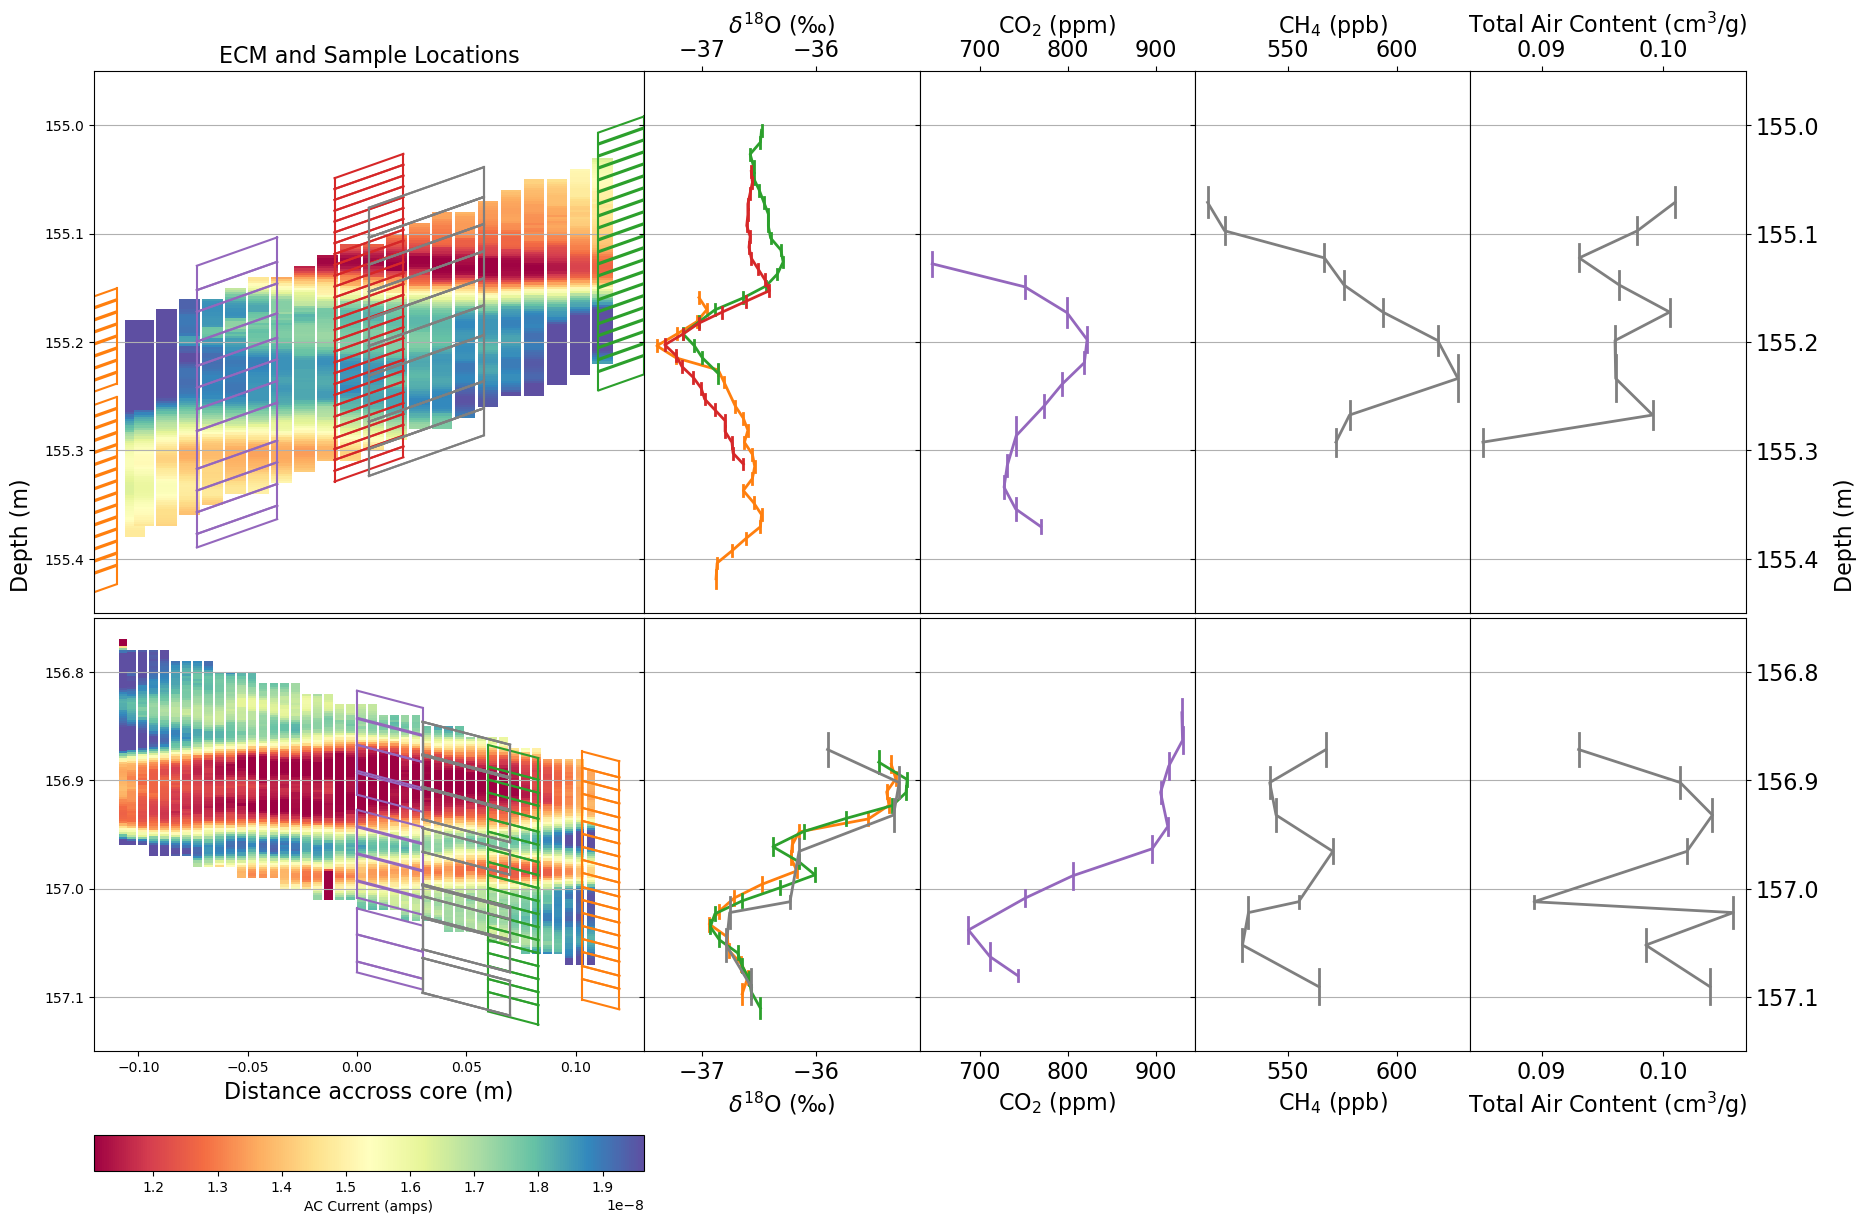

In [12]:
secs = [s228_4_AC,s230_4_AC]
proxies = ['d18O','co2','ch4','tac']
d_range = [[155.45, 154.95],[157.15,156.75]]
side_angles = [s228_4_AC.side_angle,s230_4_AC.side_angle]
top_angles = [s228_4_AC.top_angle,s230_4_AC.top_angle]
make_full_plot(samp_data_raw,secs,proxies,side_angles,top_angles,d_range,title=None)

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_depth_shifted'] = df['mid_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['top_depth_shifted'] = df['top_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

(<Figure size 1600x1200 with 9 Axes>,
 array([[<Axes: title={'center': 'ECM and Sample Locations'}>,
         <Axes: xlabel='$\\delta ^{18}$O (‰)'>,
         <Axes: xlabel='CO$_{2}$ (ppm)'>, <Axes: xlabel='CH$_{4}$ (ppb)'>],
        [<Axes: xlabel='Distance accross core (m)'>,
         <Axes: xlabel='$\\delta ^{18}$O (‰)'>,
         <Axes: xlabel='CO$_{2}$ (ppm)'>, <Axes: xlabel='CH$_{4}$ (ppb)'>]],
       dtype=object))

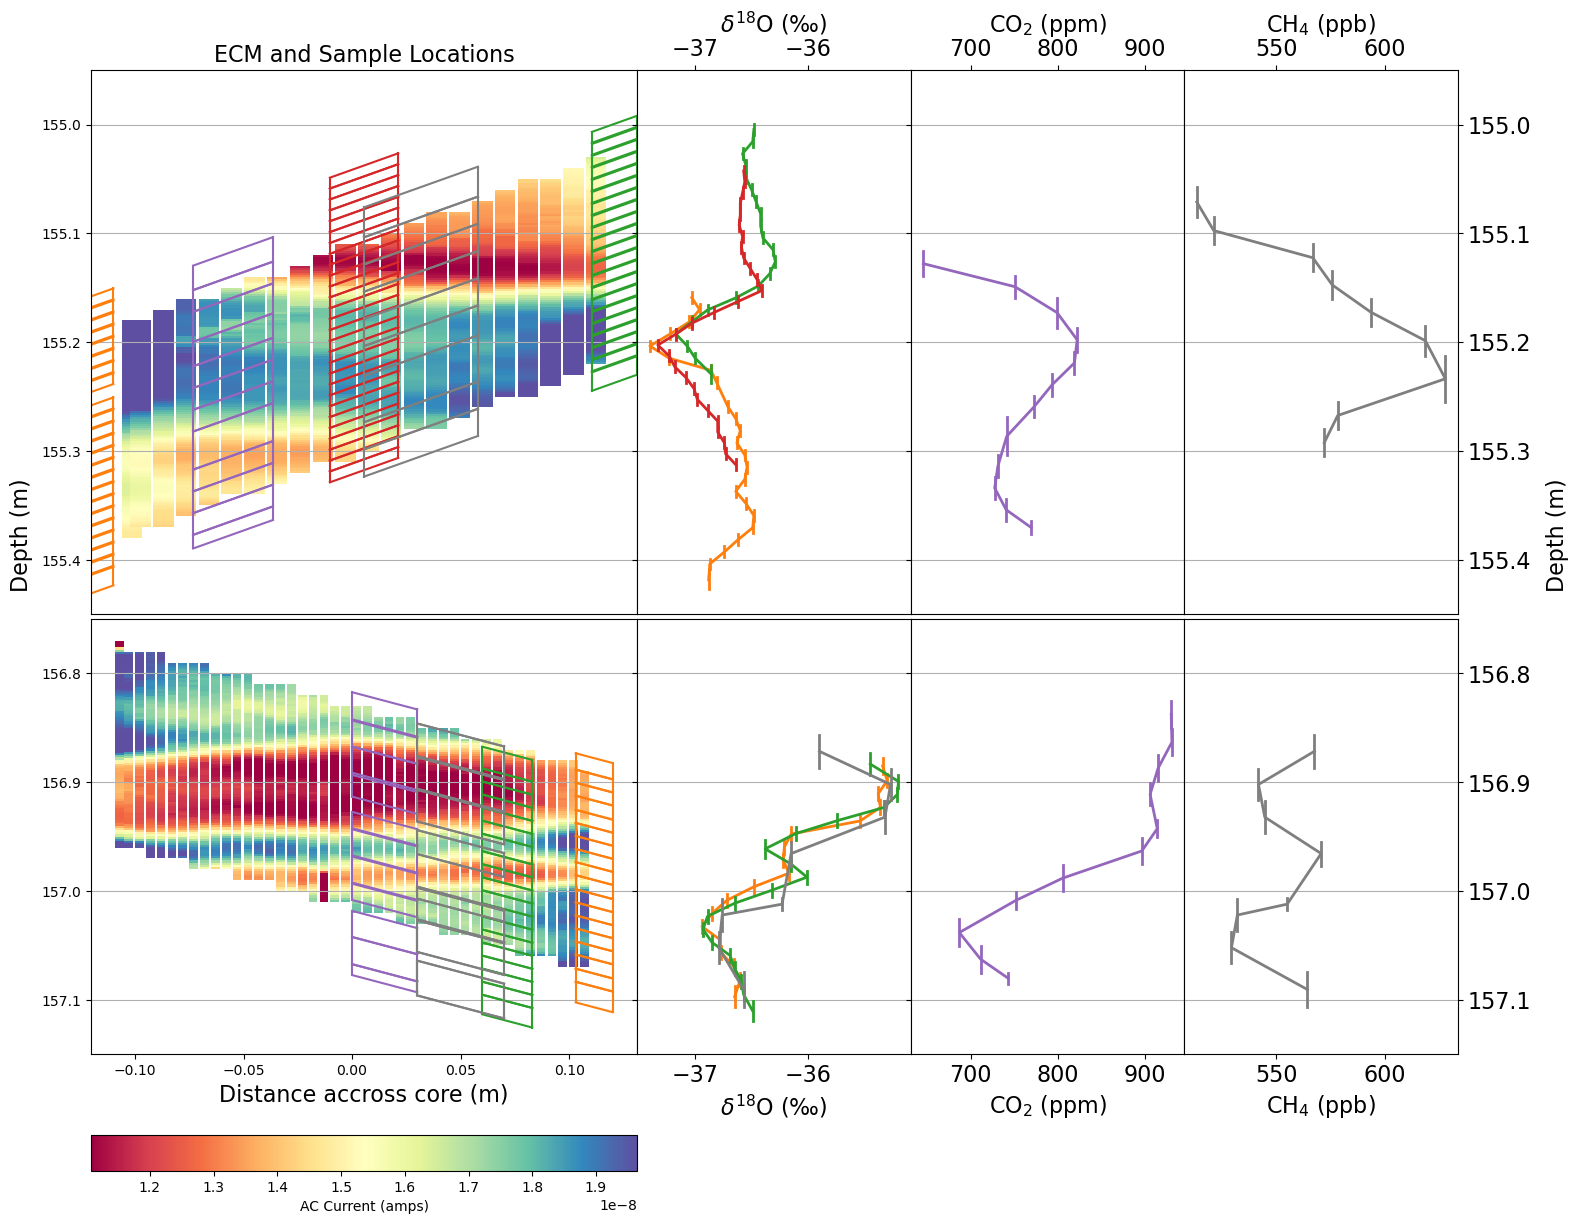

In [13]:
secs = [s228_4_AC,s230_4_AC]
proxies = ['d18O','co2','ch4']
d_range = [[155.45, 154.95],[157.15,156.75]]
side_angles = [s228_4_AC.side_angle,s230_4_AC.side_angle]
top_angles = [s228_4_AC.top_angle,s230_4_AC.top_angle]
make_full_plot(samp_data_raw,secs,proxies,side_angles,top_angles,d_range,title=None)

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_depth_shifted'] = df['mid_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['top_depth_shifted'] = df['top_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

(<Figure size 1600x1200 with 9 Axes>,
 array([[<Axes: title={'center': 'ECM and Sample Locations'}>,
         <Axes: xlabel='Fe (μg/L)'>, <Axes: xlabel='Ca (μg/L)'>,
         <Axes: xlabel='Particle Concentration  (ppb)'>],
        [<Axes: xlabel='Distance accross core (m)'>,
         <Axes: xlabel='Fe (μg/L)'>, <Axes: xlabel='Ca (μg/L)'>,
         <Axes: xlabel='Particle Concentration  (ppb)'>]], dtype=object))

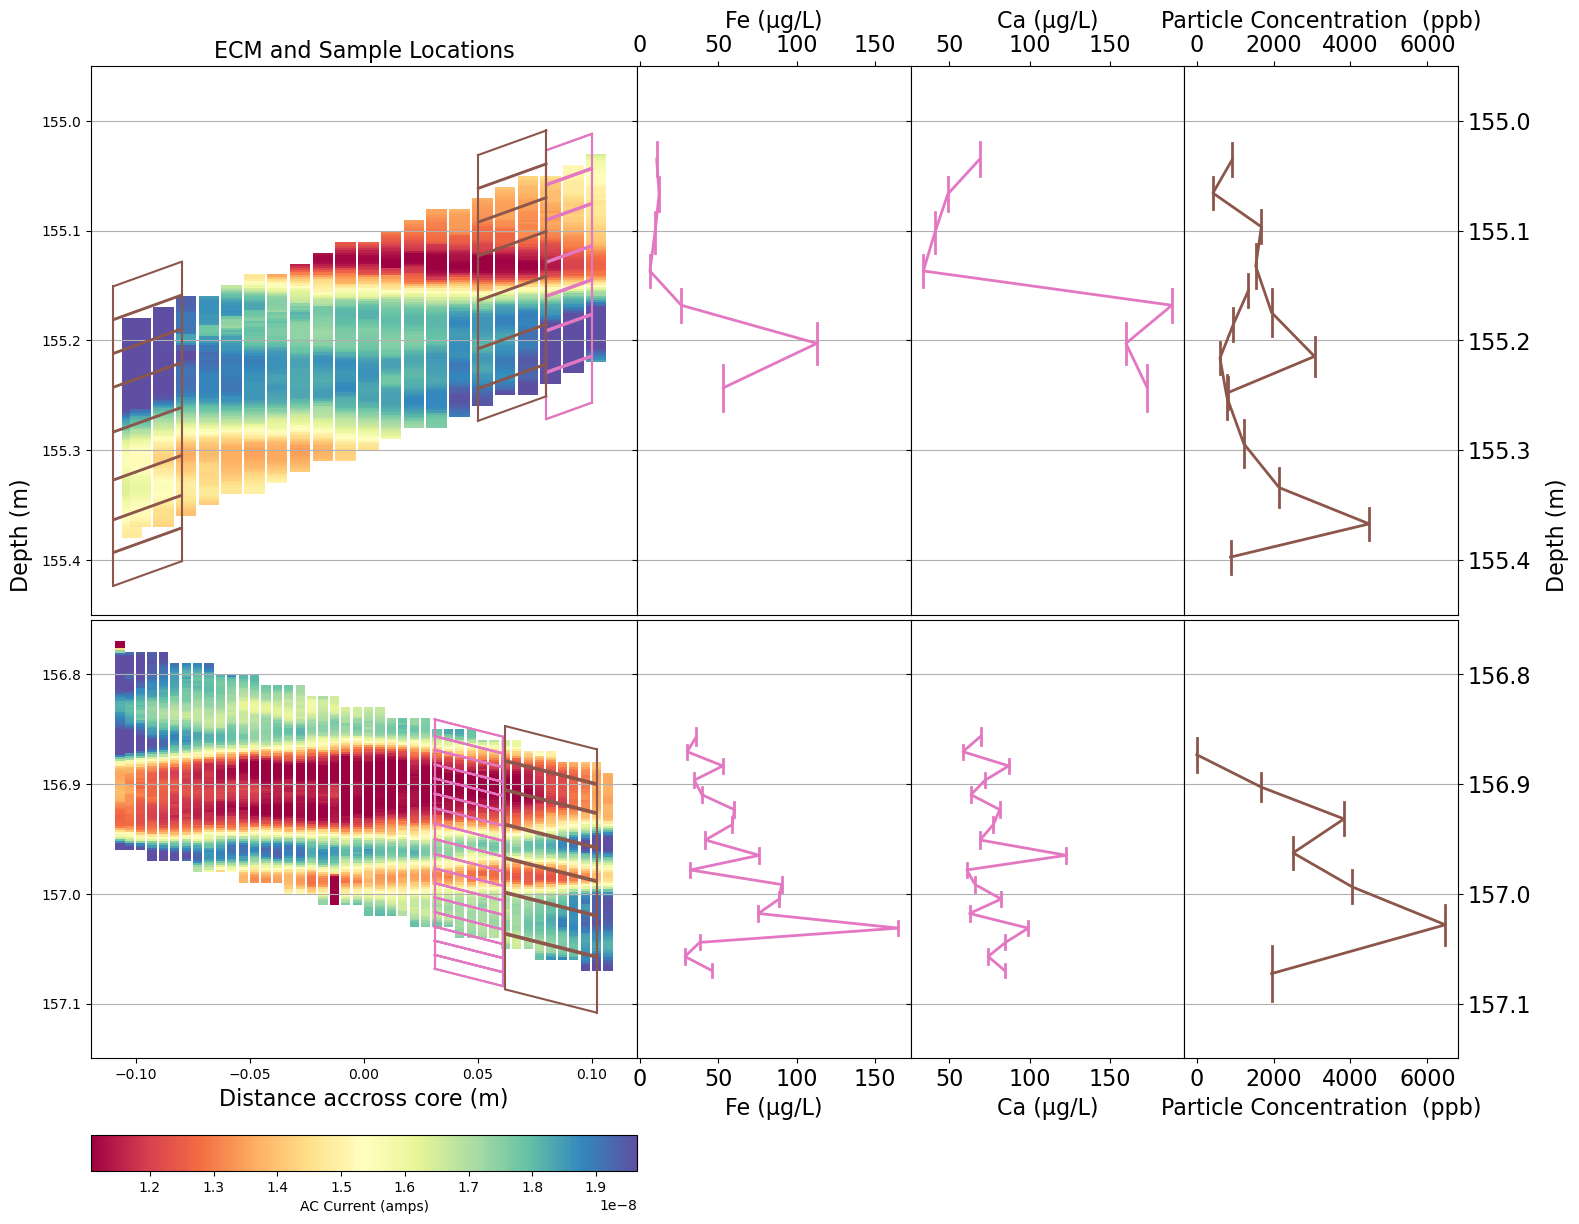

In [14]:
secs = [s228_4_AC,s230_4_AC]
proxies = ['Fe','Ca','concentration']
d_range = [[155.45, 154.95],[157.15,156.75]]
side_angles = [s228_4_AC.side_angle,s230_4_AC.side_angle]
top_angles = [s228_4_AC.top_angle,s230_4_AC.top_angle]
make_full_plot(samp_data_raw,secs,proxies,side_angles,top_angles,d_range,title=None)

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_depth_shifted'] = df['mid_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['top_depth_shifted'] = df['top_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_13454/3122480808.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

(<Figure size 1300x1200 with 7 Axes>,
 array([[<Axes: title={'center': 'ECM and Sample Locations'}>,
         <Axes: xlabel='$\\delta ^{18}$O (‰)'>,
         <Axes: xlabel='d$_{xs}$ (‰)'>],
        [<Axes: xlabel='Distance accross core (m)'>,
         <Axes: xlabel='$\\delta ^{18}$O (‰)'>,
         <Axes: xlabel='d$_{xs}$ (‰)'>]], dtype=object))

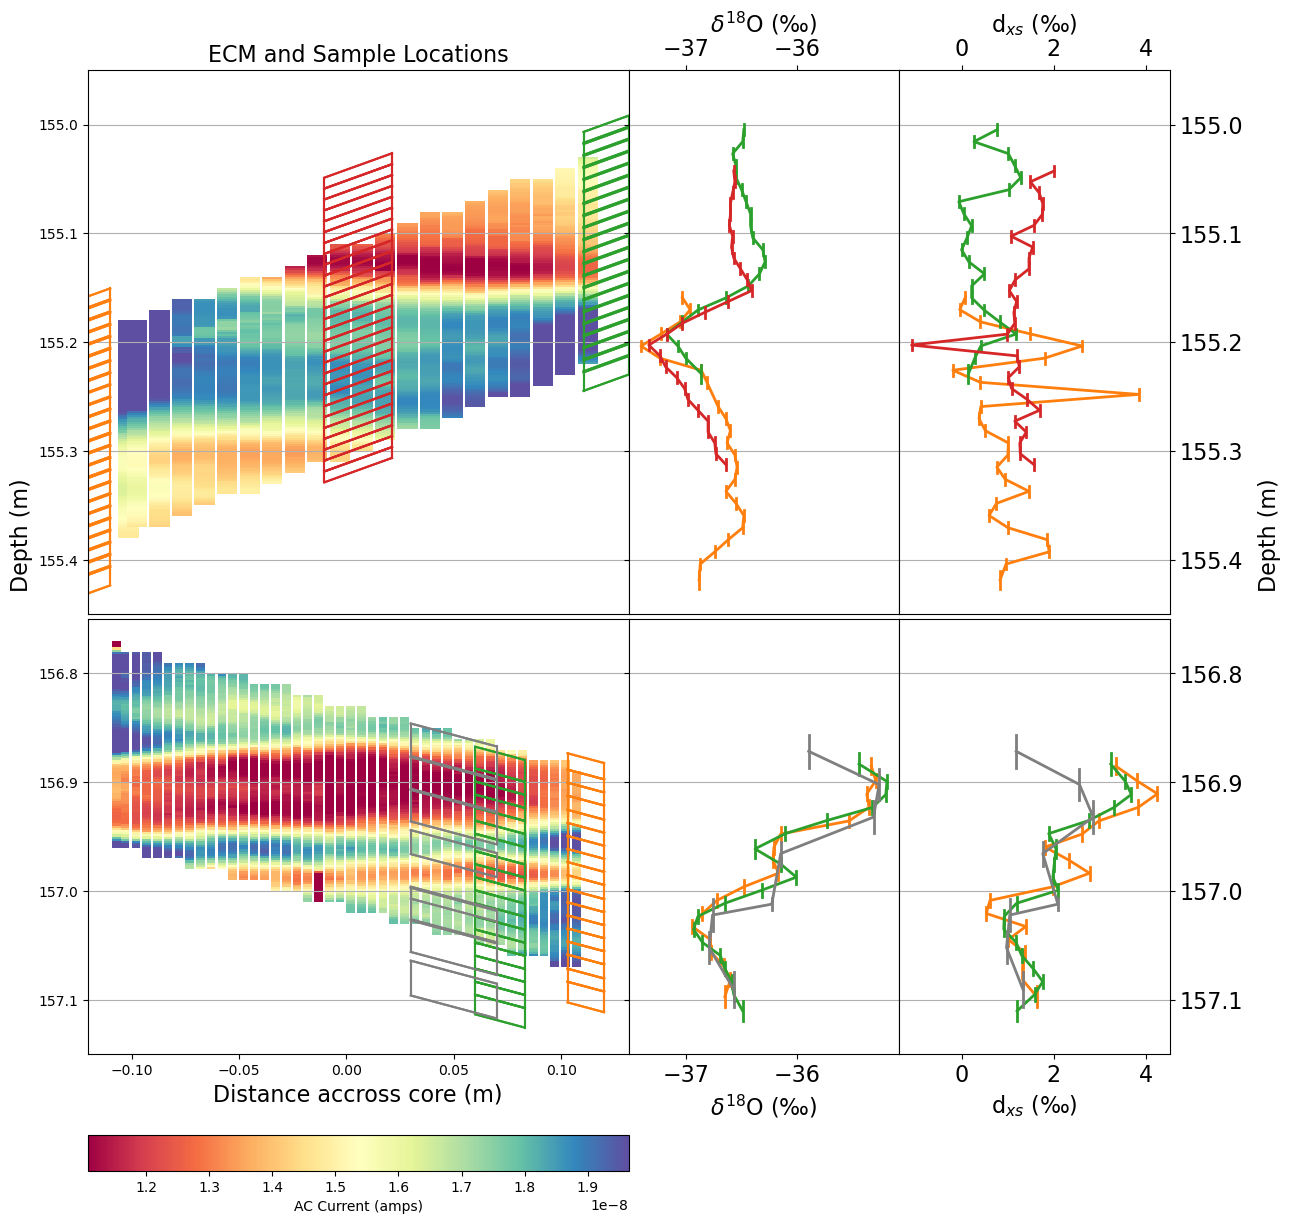

In [15]:
secs = [s228_4_AC,s230_4_AC]
proxies = ['d18O','dxs']
d_range = [[155.45, 154.95],[157.15,156.75]]
side_angles = [s228_4_AC.side_angle,s230_4_AC.side_angle]
top_angles = [s228_4_AC.top_angle,s230_4_AC.top_angle]
make_full_plot(samp_data_raw,secs,proxies,side_angles,top_angles,d_range,title=None)